In [1]:
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks
rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools

# Get ZTF fit

In [2]:
# Local Configuration
data_fink = '../'
bft_file = os.path.join(data_fink,'data','ssoBFT-latest.parquet')


In [3]:
# Threshold for selection (of non-zero values)
thres = 1e-3

# Minimum phase angle to consider
min_phase = 3

In [4]:
# ZTF filters 1: g, 2: r
filters = {'1': 'g', '2': 'r'}

S_color = {'g': -0.3928, 'r':0.2913}
sun_color = {'g': -0.3044, 'r':0.1903}

color_C = -(sun_color['g']-sun_color['r'])
color_S = -(S_color['g']-S_color['r'])

fink_colors = ['#15284F', '#F5622E']

V_minus_g = -0.2833
V_minus_r = 0.1777

In [5]:
data = pd.read_parquet(os.path.join(data_fink, 'data', 'ztf', 'sso_ZTF.parquet'))

In [6]:
data.columns


Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_median_error_phot_1',
       'HG_median_error_phot_2', 'HG_rms', 'HG_chi2red',
       'HG_median_error_phot', 'HG_dH_g', 'HG_dG_r', 'HG_dH_r', 'HG_rms_r',
       'HG_rms_g', 'HG_G_g', 'HG_H_r', 'HG_H_g', 'HG_G_r', 'HG_status',
       'HG_flag', 'HG1G2_fit', 'HG1G2_median_error_phot_1',
       'HG1G2_median_error_phot_2', 'HG1G2_dG2_g', 'HG1G2_dG1_r',
       'HG1G2_dG1_g', 'HG1G2_rms', 'HG1G2_dG2_r', 'HG1G2_G2_g', 'HG1G2_G1_r',
       'HG1G2_G1_g', 'HG1G2_G2_r', 'HG1G2_chi2red', 'HG1G2_median_error_phot',
       'HG1G2_dH_g', 'HG1G2_dH_r', 'HG1G2_rms_r', 'HG1G2_rms_g', 'HG1G2_H_r',
       'HG1G2_H_g', 'HG1G2_status', 'HG1G2_flag', 'mean_astrometry',
       'max_phase_g', 'max_phase_r', 'SHG1G2_max_cos_lambda', 'SHG1G2_fit',
       'SHG1G2_R', 'SHG1G2_min_cos_lambda', 'SHG1G2_median_error_phot_1',
       'SHG1G2_median_error_phot_2', 'n_obs', 'SHG1G2_dG2_g', 'SHG1G2_dG1_r',
       'n_days', 'SHG1G2_dG1_g', 'SHG1G2_rms', 'SHG1G2_dG2_r', 'SHG1G2_

In [7]:
data['SHG1G2_dSpin'] = np.sqrt( (data['SHG1G2_dalpha0']*np.cos(np.radians(data['SHG1G2_delta0'])))**2 + data['SHG1G2_ddelta0']**2 )


# # Remove solutions above 90 deg of latitude
cond = data.SHG1G2_delta0 > 90
data.loc[cond,'SHG1G2_delta0'] = 90
print(f'above 90: {len(data[cond])} ')

cond = data.SHG1G2_delta0 < -90
data.loc[cond,'SHG1G2_delta0'] = -90
print(f'below 90: {len(data[cond])} ')


above 90: 0 
below 90: 0 


In [8]:
cols = ['sso_number', 'sso_name', 'sso_class',
        'orbital_elements.semi_major_axis.value',
        'orbital_elements.eccentricity.value',
        'orbital_elements.inclination.value',
        'orbital_elements.node_longitude.value',
        'orbital_elements.perihelion_argument.value',
        'orbital_elements.mean_anomaly.value',
        'orbital_elements.mean_motion.value',
        'family.family_number', 'family.family_name',
        'proper_elements.proper_semi_major_axis.value',
        'proper_elements.proper_eccentricity.value',
        'proper_elements.proper_inclination.value',
        'proper_elements.proper_sine_inclination.value',
        'tisserand_parameters.Jupiter.value',
        'albedo.value',
        'absolute_magnitude.value', 
        'diameter.value', 
        'taxonomy.class', 'taxonomy.complex', 'taxonomy.waverange', 'taxonomy.scheme', 'taxonomy.technique',
        'colors.g-r.color.value', 'colors.g-r.color.error.min', 'colors.g-r.color.error.max',
        'colors.g-r.facility', 'colors.g-r.observer', 'colors.g-r.epoch',
        'colors.g-r.delta_time', 'colors.g-r.id_filter_1',
        'colors.g-r.id_filter_2', 'colors.g-r.phot_sys', 'colors.g-r.technique',
        'spins.1.obliquity', 'spins.1.RA0.value', 'spins.1.DEC0.value', 'spins.1.RA0.error.max', 'spins.1.DEC0.error.max',
        'spins.1.long.value', 'spins.1.lat.value', 'spins.1.technique',
        'spins.2.obliquity', 'spins.2.RA0.value', 'spins.2.DEC0.value', 'spins.2.RA0.error.max', 'spins.2.DEC0.error.max',
        'spins.2.long.value', 'spins.2.lat.value', 'spins.2.technique',
        'spins.3.obliquity', 'spins.3.RA0.value', 'spins.3.DEC0.value', 'spins.3.RA0.error.max', 'spins.3.DEC0.error.max',
        'spins.3.long.value', 'spins.3.lat.value', 'spins.3.technique',
        'spins.4.obliquity', 'spins.4.RA0.value', 'spins.4.DEC0.value', 'spins.4.RA0.error.max', 'spins.4.DEC0.error.max',
        'spins.4.long.value', 'spins.4.lat.value', 'spins.4.technique'
       ]      
bft = pd.read_parquet(bft_file, columns=cols)

In [9]:
data = data.merge( bft, left_on='name', right_on='sso_name', how='left' )

In [10]:
# data

In [11]:
thres = 1e-3

# HG Parameeter
mask_HG_g = (data.HG_H_g.notna()) & (data.HG_G_g.notna())
mask_HG_r = (data.HG_H_r.notna()) & (data.HG_G_r.notna())
mask_HG_fit = (data.HG_fit==0)  & (data.HG_status>=2)
mask_HG  = mask_HG_g & mask_HG_r & mask_HG_fit

# HG1G2 parameters
mask_HG1G2_g = (data.HG1G2_G1_g>thres)  & (data.HG1G2_G2_g>thres) & ((1-data.HG1G2_G1_g-data.HG1G2_G2_g)>thres)
mask_HG1G2_r = (data.HG1G2_G1_r>thres)  & (data.HG1G2_G2_r>thres) & ((1-data.HG1G2_G1_r-data.HG1G2_G2_r)>thres)
mask_HG1G2_fit = (data.HG1G2_fit==0)  & (data.HG1G2_status>=2)
mask_HG1G2 = mask_HG1G2_fit & mask_HG1G2_g & mask_HG1G2_r

# SHG1G2 ZTF
mask_SHG1G2_g = (data.SHG1G2_G1_g>thres)  & (data.SHG1G2_G2_g>thres) & ((1-data.SHG1G2_G1_g-data.SHG1G2_G2_g)>thres)
mask_SHG1G2_r = (data.SHG1G2_G1_r>thres)  & (data.SHG1G2_G2_r>thres) & ((1-data.SHG1G2_G1_r-data.SHG1G2_G2_r)>thres)
mask_SHG1G2_ZTF = mask_SHG1G2_g & mask_SHG1G2_r
mask_SHG1G2_fit = (data.SHG1G2_fit==0)  & (data.SHG1G2_status>=2)
mask_SHG1G2 = mask_SHG1G2_fit & mask_SHG1G2_ZTF 


# Spin solution suspicous: RA=={0,180,360}, DEC==0
maskSpin = (data.SHG1G2_alpha0>thres) & ( np.abs(360-data.SHG1G2_alpha0)>thres )  & \
           ( np.abs(data.SHG1G2_alpha0-180)>thres) & ( np.abs(data.SHG1G2_delta0)>thres ) 

# Phase coverage
maskPhase = data.min_phase<2.5

# Global mask
mask = mask_HG1G2 & mask_SHG1G2

# Global mask
maskFINK = mask_SHG1G2 & maskSpin #& maskPhase


print(f' All data       : {len(data):6d}  ({100:>6.2f}%)')
print()
print(f'  Mask HG g      : {len(data[mask_HG_g]):6d}  ({100.*len(data[mask_HG_g])/len(data):>6.2f}%)')
print(f'  Mask HG r      : {len(data[mask_HG_r]):6d}  ({100.*len(data[mask_HG_r])/len(data):>6.2f}%)')
print(f'  Mask HG g+r    : {len(data[mask_HG]):6d}  ({100.*len(data[mask_HG])/len(data):>6.2f}%)')
print()
print(f'  Mask HG1G2 g   : {len(data[mask_HG1G2_g]):6d}  ({100.*len(data[mask_HG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 r   : {len(data[mask_HG1G2_r]):6d}  ({100.*len(data[mask_HG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask HG1G2 g+r : {len(data[mask_HG1G2]):6d}  ({100.*len(data[mask_HG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask SHG1G2 g  : {len(data[mask_SHG1G2_g]):6d}  ({100.*len(data[mask_SHG1G2_g])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 r  : {len(data[mask_SHG1G2_r]):6d}  ({100.*len(data[mask_SHG1G2_r])/len(data):>6.2f}%)')
print(f'  Mask SHG1G2 g+r: {len(data[mask_SHG1G2]):6d}  ({100.*len(data[mask_SHG1G2])/len(data):>6.2f}%)')
print()
print(f'  Mask Spin      : {len(data[maskSpin]):6d}  ({100.*len(data[maskSpin])/len(data):>6.2f}%)')
print()
print(f'  Mask (both)    : {len(data[mask]):6d}  ({100.*len(data[mask])/len(data):>6.2f}%)')
for min_phase in [2,3,4,5]:
    maskPhase = data.min_phase<min_phase
    print(f'  Mask phase {min_phase}  : {len(data[maskPhase]):6d}  ({100.*len(data[maskPhase])/len(data):>6.2f}%)')


# len(data), len(data[mask]), len(data[mask_HG1G2]), len(data[mask_HG1G2sp]), len(data[mask_SHG1G2_g]), len(data[mask_SHG1G2_r]), len(data[mask_SHG1G2])

 All data       : 120949  (100.00%)

  Mask HG g      : 120651  ( 99.75%)
  Mask HG r      : 120653  ( 99.76%)
  Mask HG g+r    : 118312  ( 97.82%)

  Mask HG1G2 g   :  62804  ( 51.93%)
  Mask HG1G2 r   :  67827  ( 56.08%)
  Mask HG1G2 g+r :  46254  ( 38.24%)

  Mask SHG1G2 g  :  78530  ( 64.93%)
  Mask SHG1G2 r  :  83479  ( 69.02%)
  Mask SHG1G2 g+r:  63099  ( 52.17%)

  Mask Spin      : 117078  ( 96.80%)

  Mask (both)    :  40117  ( 33.17%)
  Mask phase 2  :  61691  ( 51.01%)
  Mask phase 3  :  84622  ( 69.97%)
  Mask phase 4  :  99015  ( 81.87%)
  Mask phase 5  : 107296  ( 88.71%)


# Abs mag

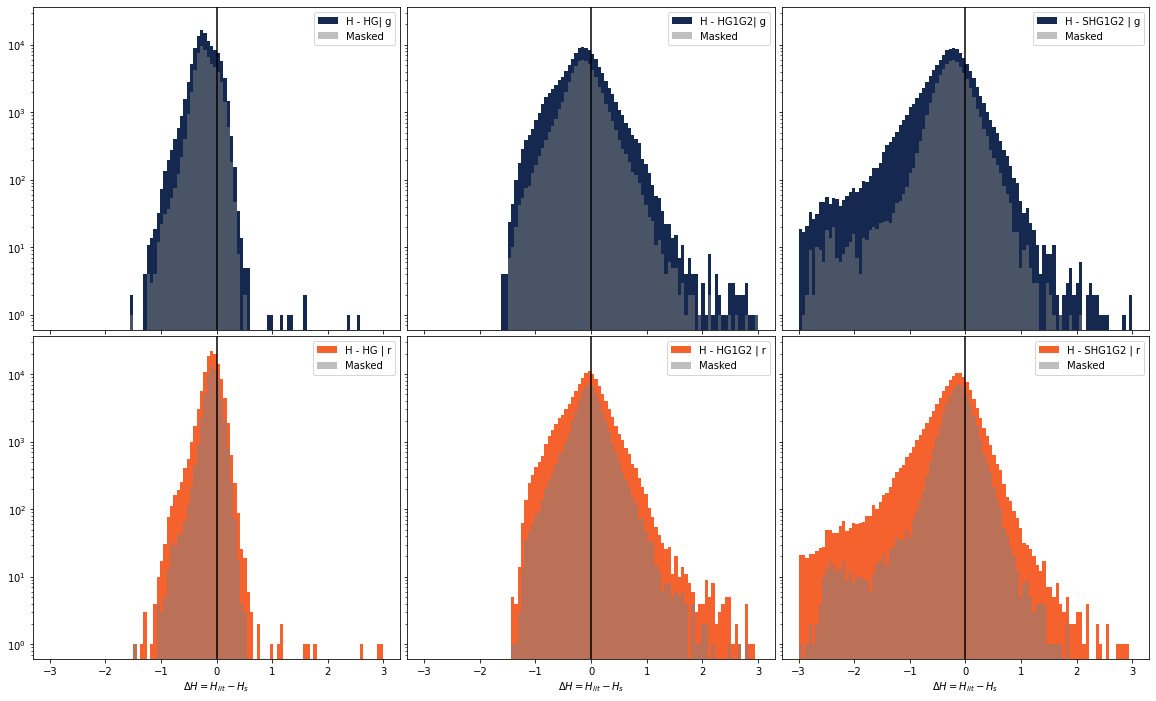

In [12]:
# Different colors
fig, ax = plt.subplots(2, 3, figsize=(20,12), sharex=True, sharey=True, gridspec_kw={'hspace':0.02, 'wspace':0.02})

r = [-3,3]
b = 100


# HG
x = (data['absolute_magnitude.value'] - data.HG_H_g) - V_minus_g
ax[0,0].hist( x, range=r, bins=b, label='H - HG| g', color=fink_colors[0] )
ax[0,0].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.HG_H_r) - V_minus_r
ax[1,0].hist( x, range=r, bins=b, label='H - HG | r', color=fink_colors[1] )
ax[1,0].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )



# HG1G2
x = (data['absolute_magnitude.value'] - data.HG1G2_H_g) - V_minus_g
ax[0,1].hist( x, range=r, bins=b, label='H - HG1G2| g' , color=fink_colors[0] )
ax[0,1].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.HG1G2_H_r) - V_minus_r
ax[1,1].hist( x, range=r, bins=b, label='H - HG1G2 | r', color=fink_colors[1] )
ax[1,1].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )


# SHG1G2
x = (data['absolute_magnitude.value'] - data.SHG1G2_H_g) - V_minus_g
ax[0,2].hist( x, range=r, bins=b, label='H - SHG1G2 | g', color=fink_colors[0] )
ax[0,2].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )

x = (data['absolute_magnitude.value'] - data.SHG1G2_H_r) - V_minus_r
ax[1,2].hist( x, range=r, bins=b, label='H - SHG1G2 | r', color=fink_colors[1] )
ax[1,2].hist( x[maskFINK], range=r, bins=b, label='Masked', color='grey', alpha=0.5 )


for a in ax.ravel():
    a.set_xlabel('$\Delta H = H_{lit} - H_s$')
    a.legend(loc='upper right')
    a.set_yscale('log')
    a.axvline(0, color='black')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'H.png'), facecolor='white')

# Spin distribution

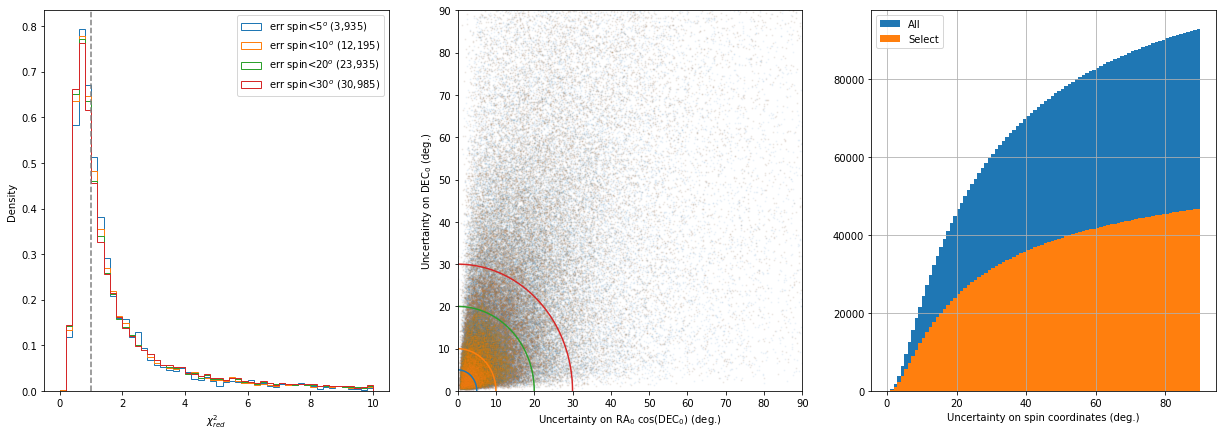

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(21,7))


# Histogram of chi2
for err in [5,10,20,30]:
    cond = maskFINK
    cond = cond*(data.SHG1G2_dSpin<=err)
    ax[0].hist(data.loc[cond,'SHG1G2_chi2red'], bins=50, histtype='step', density=True, range=[0,10],
               label=f'err spin<{err:d}$^o$ ({len(data[cond]):,d})')

    theta = np.linspace(0, np.pi/2, num=90 )
    ax[1].plot( err*np.cos(theta), err*np.sin(theta) )
    
ax[0].axvline(1, ls='--', color='grey')
ax[0].set_xlabel(r'$\chi^2_{red}$')
ax[0].set_ylabel('Density')
ax[0].legend()


# Scatter dRA dDEC
ax[1].scatter( data.SHG1G2_dalpha0*np.cos(np.radians(data['SHG1G2_delta0'])), data.SHG1G2_ddelta0, s=1, alpha=0.05 )
ax[1].scatter( data.loc[maskFINK,'SHG1G2_dalpha0']*np.cos(np.radians(data.loc[maskFINK,'SHG1G2_delta0'])), data.loc[maskFINK,'SHG1G2_ddelta0'], s=1, alpha=0.05 )
ax[1].set_xlim(0,90)
ax[1].set_ylim(0,90)

ax[1].set_xlabel('Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)')
ax[1].set_ylabel('Uncertainty on DEC$_0$ (deg.)')

# Cumulative dSpin
r = [0,90]
b = 90
ax[2].hist( data.SHG1G2_dSpin, cumulative=True, density=False, range=r, bins=b, label='All' )
ax[2].hist( data.loc[maskFINK,'SHG1G2_dSpin'], cumulative=True, density=False, range=r, bins=b, label='Select' )

ax[2].grid()
ax[2].set_xlabel('Uncertainty on spin coordinates (deg.)')
ax[2].legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)


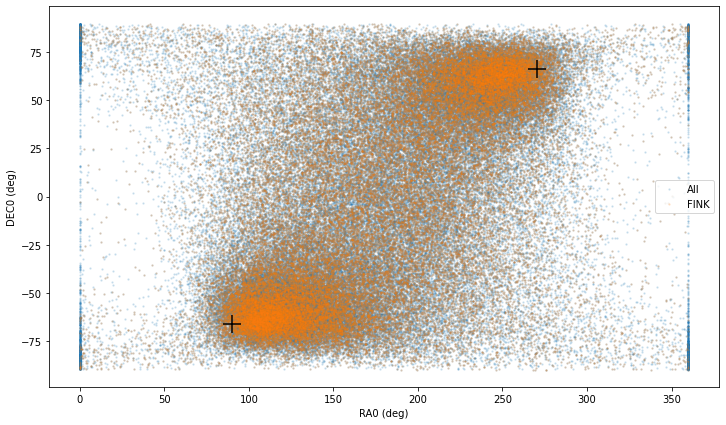

In [16]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'SHG1G2_alpha0'
yax = 'SHG1G2_delta0'

# All
cond = data.ssnamenr==data.ssnamenr
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15, label='All')

# FINK sample
cond = maskFINK
ax.scatter( data.loc[cond,xax], data.loc[cond,yax], s=2, alpha=0.15, label='FINK')


# Ecliptic poles
coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )

coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')
ax.legend()

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_bulk.png'), facecolor='white')


- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

Text(0.5, 0, 'DEC_0')

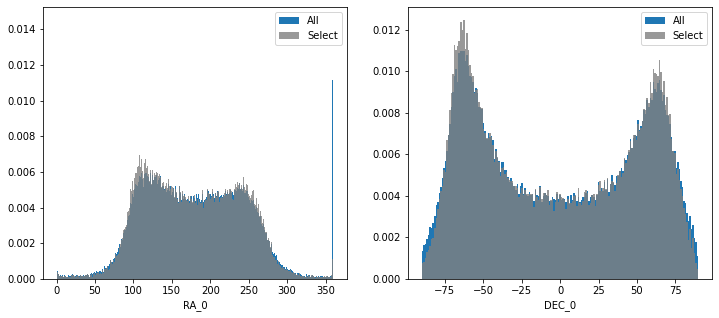

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].hist( data.SHG1G2_alpha0, range=[0,360], bins=361, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'SHG1G2_alpha0'], range=[0,360], bins=361, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend()
ax[0].set_xlabel('RA_0')

ax[1].hist( data.SHG1G2_delta0, range=[-90,90], bins=181, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'SHG1G2_delta0'], range=[-90,90], bins=181, density=True, label='Select', color='grey', alpha=0.8 )
ax[1].legend()
ax[1].set_xlabel('DEC_0')

In [20]:
# Flip half of the solution
cond = (data.index %2 ==0 )
xax = 'SHG1G2_alpha0'
yax = 'SHG1G2_delta0'

data.loc[cond,xax] = (data.loc[cond,xax]+180) % 360
data.loc[cond,yax] = -data.loc[cond,yax]

# Convert to EC
coords = SkyCoord(ra=data.loc[cond,xax].values*u.deg, dec=data.loc[cond,yax].values*u.deg, distance=200*u.parsec, frame='hcrs')
data.loc[cond,'lon'] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond,'lat'] = coords.heliocentricmeanecliptic.lat.value

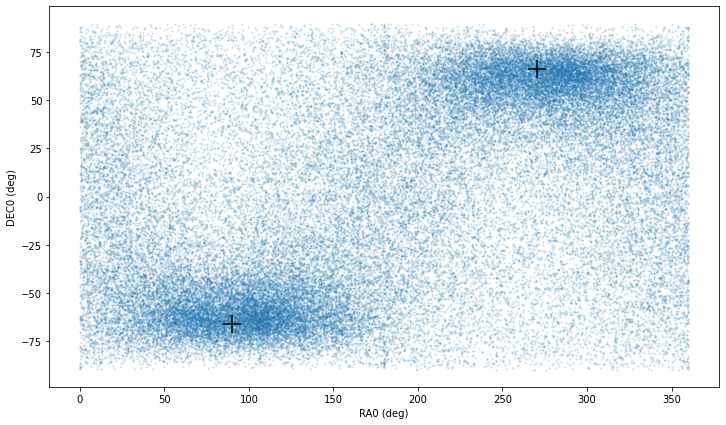

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

xax = 'SHG1G2_alpha0'
yax = 'SHG1G2_delta0'

# Sample FINK
ax.scatter( data.loc[maskFINK,xax], 
            data.loc[maskFINK,yax], 
            s=2, alpha=0.15)

# Ecliptic poles
coords = SkyCoord(lon=0.1*u.degree, lat=89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )
coords = SkyCoord(lon=0.1*u.degree, lat=-89.9*u.degree, distance=200*u.parsec, frame='heliocentricmeanecliptic')
ax.scatter( coords.hcrs.ra.value, coords.hcrs.dec.value, marker='+', s=300,color='black' )


ax.set_xlabel('RA0 (deg)')
ax.set_ylabel('DEC0 (deg)')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_selected.png'), facecolor='white')


# Compare with literature

In [22]:
data['spins.1.technique'].value_counts()

spins.1.technique
LC        15663
LCI        9833
LC+TPM      568
TE           50
ADAM         45
LC-TPM       40
LC+Occ       18
Radar        18
SPACE         6
A-M           5
SAGE          4
LC+IM         4
TE-Occ        1
Bin-IM        1
Name: count, dtype: int64

In [23]:
# Compute angular distances
spin_version = np.array(['A','B'])

for ks in ['1','2','3','4']:
    data[f'spins.{ks}.distance'] = np.nan
    cond = (~data[f'spins.{ks}.RA0.value'].isna())
    
    #------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond,f'spins.{ks}.distance.A'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'SHG1G2_alpha0','SHG1G2_delta0']].apply(
        lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.A'] = (data.loc[cond,f'spins.{ks}.RA0.value']-data.loc[cond,'SHG1G2_alpha0'] ) * np.cos(np.radians(data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.A'] = (data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'SHG1G2_delta0'] )
    data.loc[cond,f'spins.{ks}.RA.A'] = data.loc[cond,f'spins.{ks}.RA0.value']
    data.loc[cond,f'spins.{ks}.DEC.A'] = data.loc[cond,f'spins.{ks}.DEC0.value']

    #------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond,f'spins.{ks}.distance.B'] = data.loc[cond,[f'spins.{ks}.RA0.value',f'spins.{ks}.DEC0.value', 'SHG1G2_alpha0','SHG1G2_delta0']].apply(
        lambda x: np.degrees(angular_separation( np.radians( (x[0]+180) % 360 ), np.radians(-x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
    )
    data.loc[cond,f'spins.{ks}.delta_RA.B'] = ( ((data.loc[cond,f'spins.{ks}.RA0.value']+180.0) % 360 )-data.loc[cond,'SHG1G2_alpha0'] ) * np.cos(np.radians(-data.loc[cond,f'spins.{ks}.DEC0.value']))
    data.loc[cond,f'spins.{ks}.delta_DEC.B'] = (-data.loc[cond,f'spins.{ks}.DEC0.value']-data.loc[cond,'SHG1G2_delta0'] )
    data.loc[cond,f'spins.{ks}.RA.B'] = ((data.loc[cond,f'spins.{ks}.RA0.value']+180.0) % 360 )
    data.loc[cond,f'spins.{ks}.DEC.B'] = -data.loc[cond,f'spins.{ks}.DEC0.value']
    
    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.closest'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: int(np.argmin(x)), axis=1 )
    data = data.astype({f'spins.{ks}.closest':'Int64'})

    data.loc[cond,f'spins.{ks}.distance'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                            f'spins.{ks}.distance.B']].apply( lambda x: np.min(x), axis=1 )
    data.loc[cond,f'spins.{ks}.version'] = data.loc[cond, [f'spins.{ks}.distance.A', 
                                                           f'spins.{ks}.distance.B']].apply( lambda x: spin_version[np.argmin(x)], axis=1 )

    #------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond,f'spins.{ks}.delta_RA'] = data.loc[cond, [f'spins.{ks}.delta_RA.A',
                                                            f'spins.{ks}.delta_RA.B', 
                                                            f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.delta_DEC'] = data.loc[cond, [f'spins.{ks}.delta_DEC.A',
                                                             f'spins.{ks}.delta_DEC.B', 
                                                             f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.RA'] = data.loc[cond, [f'spins.{ks}.RA.A',
                                                      f'spins.{ks}.RA.B', 
                                                      f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )
    data.loc[cond,f'spins.{ks}.DEC'] = data.loc[cond, [f'spins.{ks}.RA.A',
                                                       f'spins.{ks}.RA.B', 
                                                       f'spins.{ks}.closest']].apply( lambda x: x[int(x[2])], axis=1 )

    
# Select the closest angularly
cond = ~data[f'spins.1.distance'].isna()
data.loc[cond,'spins.closest'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: int(np.argmin(x)), axis=1 )
data = data.astype({'spins.closest':'Int64'})

data.loc[cond,'spins.distance'] = data.loc[cond,['spins.1.distance','spins.2.distance','spins.3.distance','spins.4.distance']].apply( lambda x: np.min(x), axis=1 )
data.loc[cond,'spins.delta_RA'] = data.loc[cond, [f'spins.1.delta_RA',
                                                  f'spins.2.delta_RA',
                                                  f'spins.3.delta_RA',
                                                  f'spins.4.delta_RA', 
                                                  f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.delta_DEC'] = data.loc[cond, [f'spins.1.delta_DEC',
                                                   f'spins.2.delta_DEC',
                                                   f'spins.3.delta_DEC',
                                                   f'spins.4.delta_DEC', 
                                                   f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )

data.loc[cond,'spins.err_RA'] = data.loc[cond, [f'spins.1.RA0.error.max',
                                                f'spins.2.RA0.error.max',
                                                f'spins.3.RA0.error.max',
                                                f'spins.4.RA0.error.max', 
                                                f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.err_DEC'] = data.loc[cond, [f'spins.1.DEC0.error.max',
                                                 f'spins.2.DEC0.error.max',
                                                 f'spins.3.DEC0.error.max',
                                                 f'spins.4.DEC0.error.max', 
                                                 f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )

data.loc[cond,'spins.RA'] = data.loc[cond, [f'spins.1.RA',
                                            f'spins.2.RA',
                                            f'spins.3.RA',
                                            f'spins.4.RA', 
                                            f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )
data.loc[cond,'spins.DEC'] = data.loc[cond, [f'spins.1.DEC',
                                             f'spins.2.DEC',
                                             f'spins.3.DEC',
                                             f'spins.4.DEC', 
                                             f'spins.closest']].apply( lambda x: x[int(x[4])], axis=1 )


/tmp/ipykernel_761169/3374077660.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[cond,f'spins.{ks}.version'] = data.loc[cond, [f'spins.{ks}.distance.A',
/tmp/ipykernel_761169/3374077660.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[cond,f'spins.{ks}.delta_RA'] = data.loc[cond, [f'spins.{ks}.delta_RA.A',
/tmp/ipykernel_761169/3374077660.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [24]:
for c in ['spins.RA','spins.DEC','spins.err_RA', 'spins.err_DEC']:
    missing = data[c].isna()
    data.loc[missing,c] = 15.

In [25]:
for c in ['spins.RA','spins.DEC','spins.err_RA', 'spins.err_DEC']:
    missing = data[c].isna()
    print(c, len(data[missing]))
    data[c] = data[c].astype(float)
len(data)

spins.RA 0
spins.DEC 0
spins.err_RA 0
spins.err_DEC 0


120949

In [26]:
data.loc[cond,'spins.dSpin'] = np.sqrt( (data.loc[cond,'spins.err_RA']*np.cos(np.radians(data.loc[cond,'spins.DEC'])))**2 + data.loc[cond,'spins.err_DEC']**2 )


/tmp/ipykernel_761169/1164014787.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[cond,'spins.dSpin'] = np.sqrt( (data.loc[cond,'spins.err_RA']*np.cos(np.radians(data.loc[cond,'spins.DEC'])))**2 + data.loc[cond,'spins.err_DEC']**2 )


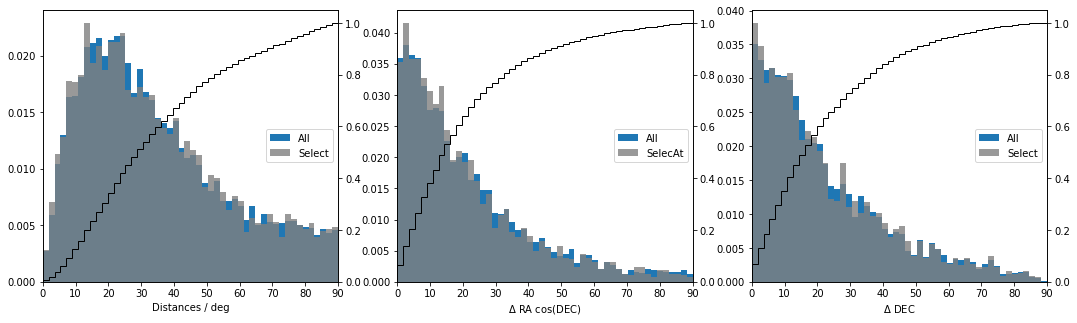

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

r = [0,90]
b = 50
ax[0].hist( data.loc[cond,'spins.distance'], range=r, bins=b, density=True, label='All' )
ax[0].hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend(loc='center right')
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( data.loc[maskFINK,'spins.distance'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[0].set_xlim(r)

ax[1].hist( data.loc[cond,'spins.delta_RA'], range=r, bins=b, density=True, label='All' )
ax[1].hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, label='SelecAt', color='grey', alpha=0.8 )
ax[1].legend(loc='center right')
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( data.loc[maskFINK,'spins.delta_RA'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[1].set_xlim(r)

ax[2].hist( data.loc[cond,'spins.delta_DEC'], range=r, bins=b, density=True, label='All' )
ax[2].hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[2].legend(loc='center right')
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( data.loc[maskFINK,'spins.delta_DEC'], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_distances.png'), facecolor='white')


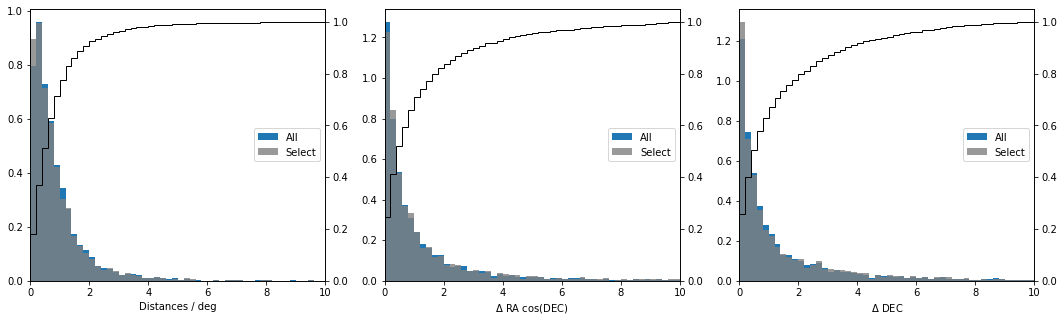

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


r = [0,10]
b = 50

x = data['spins.distance'] / np.sqrt( data['SHG1G2_dSpin']**2 + data['spins.dSpin']**2 )
ax[0].hist( x, range=r, bins=b, density=True, label='All' )
ax[0].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[0].legend(loc='center right')
ax[0].set_xlabel('Distances / deg')
ax0 = ax[0].twinx()
ax0.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[0].set_xlim(r)

x = data['spins.delta_RA'] / data['SHG1G2_dalpha0']
ax[1].hist( x, range=r, bins=b, density=True, label='All' )
ax[1].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[1].legend(loc='center right')
ax[1].set_xlabel('$\Delta$ RA cos(DEC)')
ax1 = ax[1].twinx()
ax1.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[1].set_xlim(r)

x = data['spins.delta_DEC'] / data['SHG1G2_ddelta0']
ax[2].hist( x, range=r, bins=b, density=True, label='All' )
ax[2].hist( x[maskFINK], range=r, bins=b, density=True, label='Select', color='grey', alpha=0.8 )
ax[2].legend(loc='center right')
ax[2].set_xlabel('$\Delta$ DEC')
ax2 = ax[2].twinx()
ax2.hist( x[maskFINK], range=r, bins=b, density=True, cumulative=True, histtype='step', color='black' )
ax[2].set_xlim(r)

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_distances_normed.png'), facecolor='white')

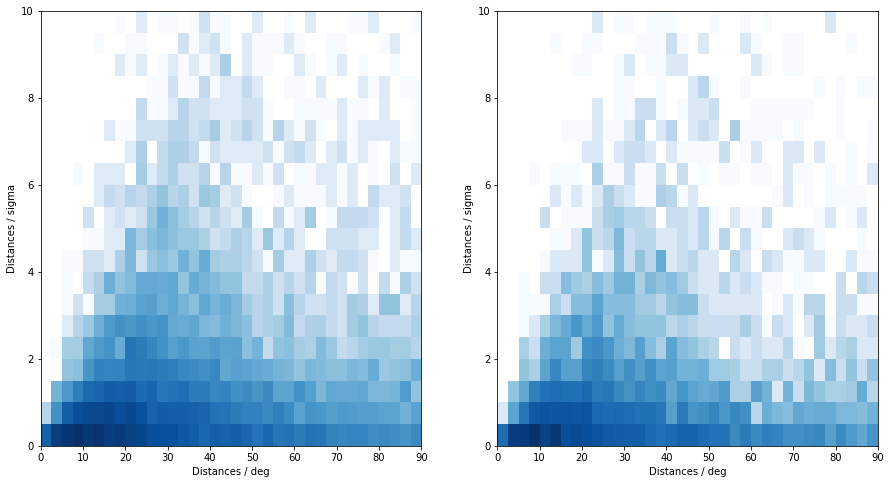

In [29]:
fig, ax = plt.subplots( 1, 2, figsize=(15,8))

r = [ [0,90],[0,10] ]
b = [36,20]

x = data['spins.distance'] 
y = data['spins.distance'] / data['SHG1G2_dSpin']
ax[0].hist2d( x, y, label='All', range=r, bins=b, cmap='Blues', norm='log', density=True )
ax[1].hist2d( x[maskFINK], y[maskFINK], label='Select', range=r, bins=b, cmap='Blues', norm='log', density=True)

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel('Distances / deg')
    a.set_ylabel('Distances / sigma')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_distances_vs_sigma.png'), facecolor='white')

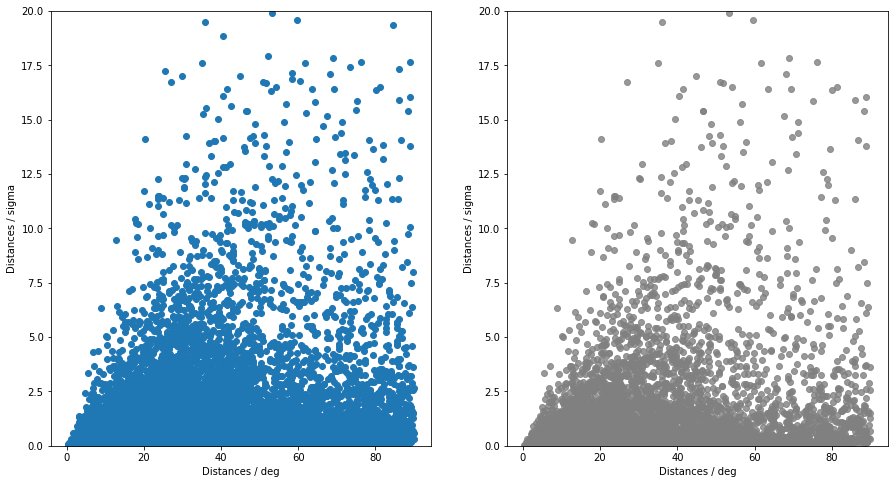

In [30]:
fig, ax = plt.subplots( 1, 2, figsize=(15,8))

r = [ [0,90],[0,20] ]
# b = [90,50]

x = data['spins.distance'] #/ data['SHG1G2_dSpin']
y = data['spins.distance'] / data['SHG1G2_dSpin']
ax[0].scatter( x, y, label='All' )
ax[1].scatter( x[maskFINK], y[maskFINK], label='Select', color='grey', alpha=0.8 )

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel('Distances / deg')
    a.set_ylabel('Distances / sigma')
    a.set_ylim(r[1])

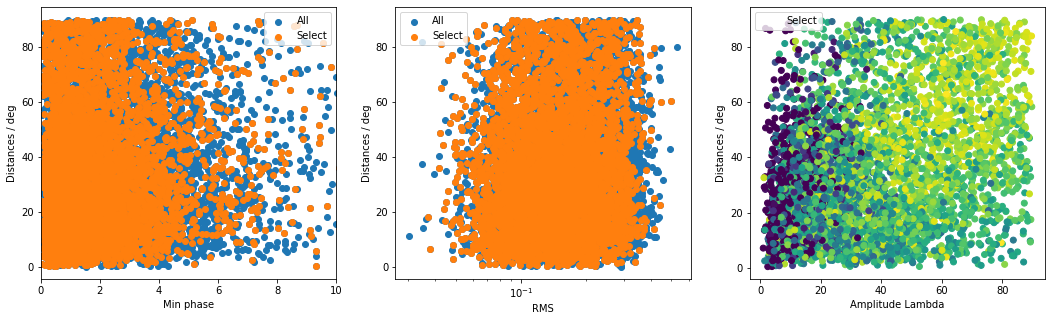

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

x = data['min_phase']
y = data['spins.distance']
ax[0].scatter( x,y, label='All' )
ax[0].scatter( x[maskFINK], y[maskFINK], label='Select' )
ax[0].legend()
ax[0].set_xlabel('Min phase')
ax[0].set_ylabel('Distances / deg')
ax[0].set_xlim(0,10)

x = data['SHG1G2_rms']
y = data['spins.distance']
ax[1].scatter( x,y, label='All' )
ax[1].scatter( x[maskFINK], y[maskFINK], label='Select' )
ax[1].legend()
ax[1].set_xlabel('RMS')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

# x = np.degrees(np.arccos(data['SHG1G2_maxCosLambda'] - data['SHG1G2_minCosLambda']))
x = np.degrees(np.arccos(data['SHG1G2_min_cos_lambda']) - np.arccos(data['SHG1G2_max_cos_lambda']))
y = data['spins.distance']
# ax[2].scatter( x, y, label='All' )
ax[2].scatter( x[maskFINK], y[maskFINK], c=data.loc[maskFINK,'SHG1G2_R'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('Amplitude Lambda')
# ax[2].set_yscale('log')
ax[2].set_ylabel('Distances / deg')

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'sky_distances_vs_obs.png'), facecolor='white')

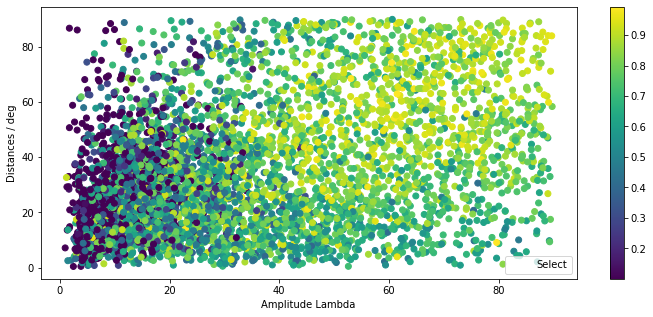

In [32]:
fig, ax = plt.subplots(figsize=(12,5))

x = np.degrees(np.arccos(data['SHG1G2_min_cos_lambda']) - np.arccos(data['SHG1G2_max_cos_lambda']))
y = data['spins.distance']
im = ax.scatter( x[maskFINK], y[maskFINK], c=data.loc[maskFINK,'SHG1G2_R'], label='Select' )
ax.legend()
ax.set_xlabel('Amplitude Lambda')
ax.set_ylabel('Distances / deg')

fig.colorbar(im)

# fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances_vs_obs.png'), facecolor='white')

Text(0, 0.5, 'Distances / deg')

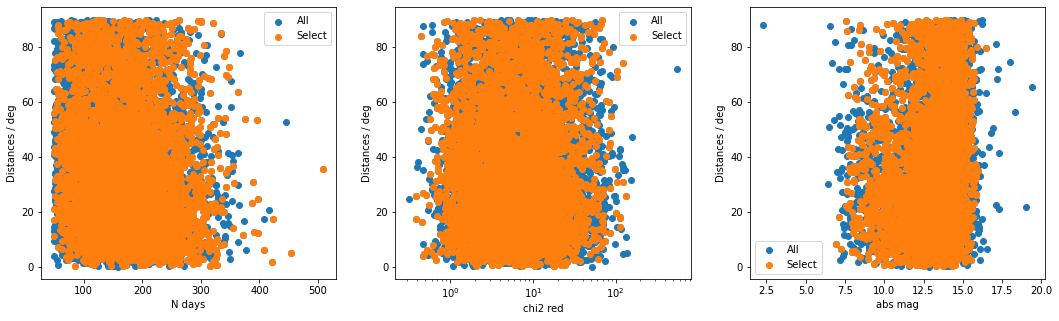

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

cond = data.ssnamenr==data.ssnamenr

ax[0].scatter( data.loc[cond,'n_days'], data.loc[cond,'spins.distance'], label='All' )
ax[0].scatter( data.loc[maskFINK,'n_days'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[0].legend()
ax[0].set_xlabel('N days')
ax[0].set_ylabel('Distances / deg')

ax[1].scatter( data.loc[cond,'SHG1G2_chi2red'], data.loc[cond,'spins.distance'], label='All' )
ax[1].scatter( data.loc[maskFINK,'SHG1G2_chi2red'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[1].legend()
ax[1].set_xlabel('chi2 red')
ax[1].set_xscale('log')
ax[1].set_ylabel('Distances / deg')

ax[2].scatter( data.loc[cond,'absolute_magnitude.value'], data.loc[cond,'spins.distance'], label='All' )
ax[2].scatter( data.loc[maskFINK,'absolute_magnitude.value'], data.loc[maskFINK,'spins.distance'], label='Select' )
ax[2].legend()
ax[2].set_xlabel('abs mag')
# ax[2].set_xscale('log')
ax[2].set_ylabel('Distances / deg')


(61860, 10182)

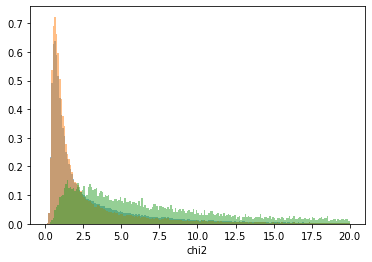

In [34]:
r = [0,20]
b = 200 
plt.hist(data['SHG1G2_chi2red'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'SHG1G2_chi2red'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'SHG1G2_chi2red'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

- fishy: the object with spins have shitty chi2red!
- Explanation: there is bias for high amplitude for LC-derived spins -> bad for HG1G2hybrid (LC not taken into account)

(61860, 10182)

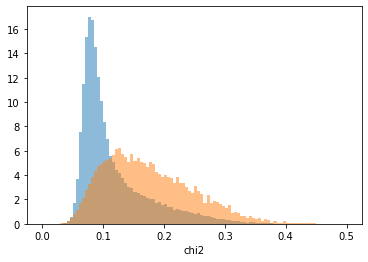

In [35]:
r = [0,0.5]
b = 100 
# plt.hist(data['SHG1G2_rms'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK,'SHG1G2_rms'], range=r, bins=b, alpha=0.5, density=True )

cond = data['spins.1.RA0.value'].notna()
plt.hist(data.loc[cond,'SHG1G2_rms'], range=r, bins=b, alpha=0.5, density=True )
# plt.xlim(0,10)
plt.xlabel('chi2')

len(data[maskFINK]), len(data[cond])

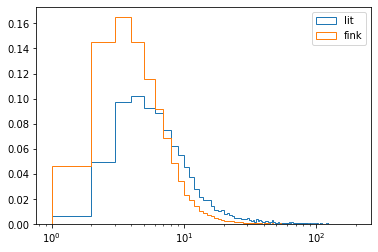

In [36]:
fig, ax = plt.subplots()

ax.hist( data.loc[cond,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='lit')
ax.hist( data.loc[maskFINK,'diameter.value'], histtype='step', bins=np.linspace(1,200,num=200), density=True, label='fink' )

ax.set_xscale('log')
ax.legend()

In [37]:
cond = maskFINK
lim_spin = 30
spin_v = '1'
cond = cond * (data[f'spins.{spin_v}.distance'] < lim_spin)
data.loc[cond,f'spins.{spin_v}.technique'].value_counts()

# plt.hist( data.loc[cond,'spins.1.distance'] )

spins.1.technique
LCI       1804
LC+TPM      89
LC          14
LC-TPM       7
ADAM         6
TE           2
LC+Occ       2
Radar        1
Name: count, dtype: int64

In [38]:
cond = maskFINK
data[cond].sort_values(by='sso_number').head(20)

,ssnamenr,HG_dG_g,HG_fit,HG_median_error_phot_1,HG_median_error_phot_2,HG_rms,HG_chi2red,HG_median_error_phot,HG_dH_g,HG_dG_r,...,spins.4.DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC,spins.err_RA,spins.err_DEC,spins.RA,spins.DEC,spins.dSpin
90786,24,0.019271,0.0,0.022072,0.021773,0.043204,4.138918,0.022072,0.019527,0.031591,...,NaN,0,6.717321,-6.755713,1.478554,3.667,2.576,66.135000,66.135000,2.972686
102542,33,0.021980,0.0,0.023779,0.024330,0.055226,5.222711,0.024150,0.019235,0.024782,...,NaN,0,45.454219,216.374952,35.989191,2.124,3.267,339.160000,339.160000,3.822785
4785,35,0.040963,0.0,0.023087,0.022691,0.165513,59.797230,0.023021,0.045771,0.055063,...,NaN,0,52.518043,45.151764,36.755879,30.000,30.000,191.581000,191.581000,41.996766
20313,38,0.035998,0.0,0.021948,0.022887,0.094311,19.039509,0.022019,0.036697,0.038518,...,NaN,0,10.959293,-8.412415,-6.963290,5.000,5.000,155.139000,155.139000,6.751386
3323,45,0.226657,0.0,0.022116,0.023200,0.259549,157.805786,0.022634,0.198259,0.156313,...,NaN,0,27.848457,-7.947385,26.937805,2.000,2.000,121.039000,121.039000,2.250214
13288,46,0.023819,0.0,0.022047,0.022010,0.073277,13.774683,0.022010,0.030860,0.028795,...,NaN,0,15.513489,-11.029427,11.592903,5.000,5.000,292.808000,292.808000,5.362528
17612,47,0.042662,0.0,0.021674,0.022142,0.109789,30.599052,0.021866,0.041531,0.058116,...,NaN,0,34.783516,212.262411,18.435323,5.000,5.000,335.521000,335.521000,6.760743
49999,49,0.022434,0.0,0.022289,0.024753,0.055910,6.231858,0.024265,0.031316,0.022957,...,NaN,<NA>,NaN,NaN,NaN,15.000,15.000,15.000000,15.000000,NaN
110952,50,0.022612,0.0,0.024323,0.027190,0.071863,7.390789,0.026356,0.033922,0.023578,...,NaN,1,55.039101,-1.249371,-55.030273,30.000,30.000,279.888000,279.888000,30.439117
91360,58,0.010610,0.0,0.024179,0.024225,0.036494,2.439156,0.024219,0.012626,0.014886,...,NaN,<NA>,NaN,NaN,NaN,15.000,15.000,15.000000,15.000000,NaN


In [39]:
cond = maskFINK
showcols = ['number','name', #'minphase','maxphase','n_days',
        'SHG1G2_alpha0','SHG1G2_delta0',
        'spins.1.RA0.value','spins.1.DEC0.value', 'spins.1.version',
        'spins.2.RA0.value','spins.2.DEC0.value', 'spins.2.version',
        'spins.1.distance', 'spins.2.distance']
data.loc[cond,showcols].sort_values(by='number').head(20)

,number,name,SHG1G2_alpha0,SHG1G2_delta0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
90786,24,Themis,81.834778,-65.991554,246.135000,64.513000,B,NaN,NaN,NaN,6.717321,NaN
102542,33,Polyhymnia,12.686310,12.499809,159.160000,-48.489000,B,33.170,-41.402,A,45.454219,57.120887
4785,35,Leukothea,145.113724,-50.421879,11.581000,13.666000,B,195.126,-5.372,A,52.518043,61.327934
20313,38,Leda,163.632843,-0.976710,155.139000,-7.940000,A,346.679,-12.214,B,10.959293,13.533038
3323,45,Eugenia,129.307281,-42.952805,121.039000,-16.015000,A,NaN,NaN,NaN,27.848457,NaN
13288,46,Hestia,305.402611,-40.461903,112.808000,28.869000,B,290.700,-8.943,A,15.513489,34.120686
17612,47,Aglaja,30.310104,-64.371323,155.521000,45.936000,B,317.916,-3.910,A,34.783516,78.930196
49999,49,Pales,84.231384,-66.141663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110952,50,Virginia,281.139015,57.968273,105.532000,34.741000,A,279.888,2.938,A,87.217279,55.039101
91360,58,Concordia,14.703384,-2.210687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
data.columns[:80]

Index(['ssnamenr', 'HG_dG_g', 'HG_fit', 'HG_median_error_phot_1',
       'HG_median_error_phot_2', 'HG_rms', 'HG_chi2red',
       'HG_median_error_phot', 'HG_dH_g', 'HG_dG_r', 'HG_dH_r', 'HG_rms_r',
       'HG_rms_g', 'HG_G_g', 'HG_H_r', 'HG_H_g', 'HG_G_r', 'HG_status',
       'HG_flag', 'HG1G2_fit', 'HG1G2_median_error_phot_1',
       'HG1G2_median_error_phot_2', 'HG1G2_dG2_g', 'HG1G2_dG1_r',
       'HG1G2_dG1_g', 'HG1G2_rms', 'HG1G2_dG2_r', 'HG1G2_G2_g', 'HG1G2_G1_r',
       'HG1G2_G1_g', 'HG1G2_G2_r', 'HG1G2_chi2red', 'HG1G2_median_error_phot',
       'HG1G2_dH_g', 'HG1G2_dH_r', 'HG1G2_rms_r', 'HG1G2_rms_g', 'HG1G2_H_r',
       'HG1G2_H_g', 'HG1G2_status', 'HG1G2_flag', 'mean_astrometry',
       'max_phase_g', 'max_phase_r', 'SHG1G2_max_cos_lambda', 'SHG1G2_fit',
       'SHG1G2_R', 'SHG1G2_min_cos_lambda', 'SHG1G2_median_error_phot_1',
       'SHG1G2_median_error_phot_2', 'n_obs', 'SHG1G2_dG2_g', 'SHG1G2_dG1_r',
       'n_days', 'SHG1G2_dG1_g', 'SHG1G2_rms', 'SHG1G2_dG2_r', 'SHG1G2_

# Obliquity

In [41]:
# Obliquity of the spin
data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
data['obliquity'] = data[['lon','lat', 'lon_orbit','lat_orbit']].apply(
    lambda x: np.degrees(angular_separation( np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3]) )) , axis=1
)


/tmp/ipykernel_761169/2383006645.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lon_orbit'] = data['orbital_elements.node_longitude.value'] - 90
/tmp/ipykernel_761169/2383006645.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lat_orbit'] = 90. - data['orbital_elements.inclination.value']
/tmp/ipykernel_761169/2383006645.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

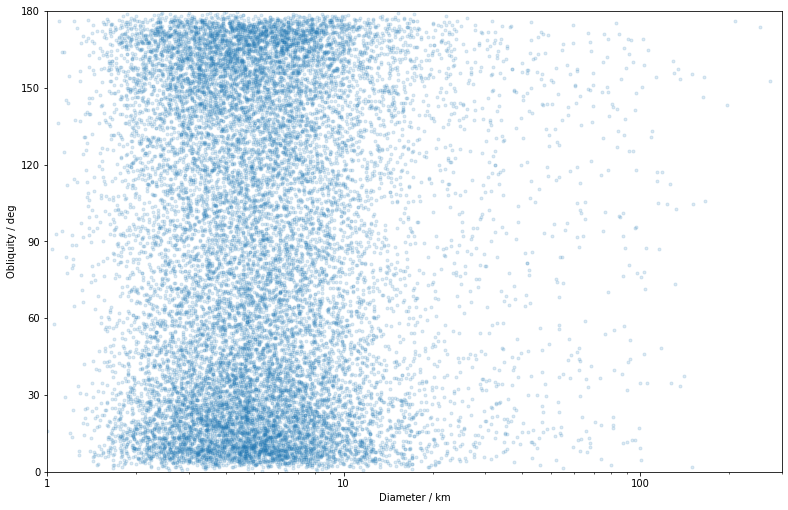

In [42]:
fig, ax = plt.subplots(figsize=(12,8), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

cond = data.ssnamenr==data.ssnamenr
cond = maskFINK
ax.scatter( data.loc[cond,'diameter.value'],
            data.loc[cond,'obliquity'], 
            marker='.',
            # color=colors[0], 
            # s=2, 
            alpha=0.15 )

ax.set_xscale('log')
ax.set_xlim(1,300)
ax.set_ylim(0,180)
ax.set_xlabel('Diameter / km')
ax.set_ylabel('Obliquity / deg')


ax.set_xticks([1,10,100])
ax.set_xticklabels(['1','10','100'])
ax.set_yticks([0,30,60,90,120,150,180])

fig.savefig( os.path.join(data_fink, 'gfx', 'models', 'obliquity_vs_diameter.png'), facecolor='white')

(array([307., 919., 782., 707., 637., 557., 487., 445., 392., 346., 296.,
        325., 306., 302., 284., 280., 268., 271., 278., 275., 254., 287.,
        242., 293., 316., 299., 312., 312., 356., 385., 448., 480., 555.,
        617., 697., 732., 297.]),
 array([  0.        ,   4.86486486,   9.72972973,  14.59459459,
         19.45945946,  24.32432432,  29.18918919,  34.05405405,
         38.91891892,  43.78378378,  48.64864865,  53.51351351,
         58.37837838,  63.24324324,  68.10810811,  72.97297297,
         77.83783784,  82.7027027 ,  87.56756757,  92.43243243,
         97.2972973 , 102.16216216, 107.02702703, 111.89189189,
        116.75675676, 121.62162162, 126.48648649, 131.35135135,
        136.21621622, 141.08108108, 145.94594595, 150.81081081,
        155.67567568, 160.54054054, 165.40540541, 170.27027027,
        175.13513514, 180.        ]),
 <BarContainer object of 37 artists>)

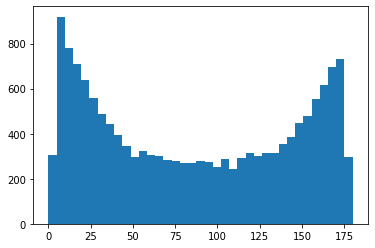

In [43]:
cond = maskFINK & (data['diameter.value']<10)
fig, ax = plt.subplots()

r = [0,180]
b = 37
ax.hist( data.loc[cond,'obliquity'], bins=b, range=r )

In [44]:
np.sqrt(2*np.pi / (5*3600)), np.sqrt(2*np.pi / (5*365.24*86400))

(0.01868330405465976, 0.00019955329064394955)

In [45]:
nu = [1e-8, 1e-4]

ti = 200
emissivity = 0.9
sigma_b = 5.670374419e-8
S_sun = 1360
beaming = 0.9
delta = 3.
pV = 0.15
A = (0.29 + 0.684*0.15) * pV

theta = ti*np.sqrt(nu) * ((beaming * delta**2 )**(3/4)) * ( (sigma_b*emissivity)**(-1/4) ) * ( ((1-A)*S_sun)**(-3/4) )

W = -0.5* theta / (1 + theta + 0.5*theta**2)

Wn = W[0]
Ww = W[1]

print(W)

[-0.01448942 -0.17681723]


In [46]:
data.loc[maskFINK,'family.family_name'].value_counts().head(30)

family.family_name
Vesta         2553
Eos           2039
Hertha        1660
Koronis       1497
Themis         922
Maria          723
Astraea        690
Eulalia        638
Eunomia        602
Phocaea        588
Hygiea         587
Baptistina     512
Minerva        480
Iduna          459
Hungaria       383
Flora          318
Adeona         317
Mnemosyne      303
Massalia       292
Levin          249
Dora           216
Euphrosyne     212
Veritas        174
Tirela         169
Eurynome       161
Hansa          160
Agnia          149
Erigone        140
Rafita         136
Taiyuan        121
Name: count, dtype: int64

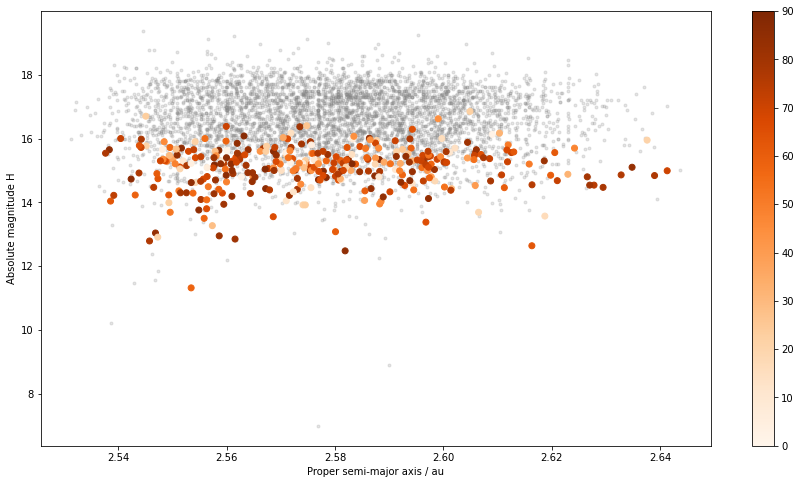

In [47]:
fig, ax = plt.subplots(figsize=(15,8))

f = 'Astraea'

cond = bft['family.family_name']==f
ax.scatter( bft.loc[cond,'proper_elements.proper_semi_major_axis.value'], bft.loc[cond,'absolute_magnitude.value'], color='grey', alpha=0.2, marker='.' )

                    
cond = maskFINK & (data['family.family_name']==f)
im = ax.scatter( data.loc[cond,'proper_elements.proper_semi_major_axis.value'],
            data.loc[cond,'absolute_magnitude.value'],
            c=np.abs(data.loc[cond,'obliquity']-90),
            vmin=0, vmax=90, alpha=1.0, marker='o', cmap='Oranges' )

ax.set_xlabel('Proper semi-major axis / au')
ax.set_ylabel('Absolute magnitude H')
fig.colorbar(im)

# Oblateness

In [48]:
damit = pd.read_csv( os.path.join(data_fink,'data','damit.csv' ) )

In [49]:
np.mean(damit.R), np.mean(damit.R2)

(0.6131972585404972, 0.7431183878107458)

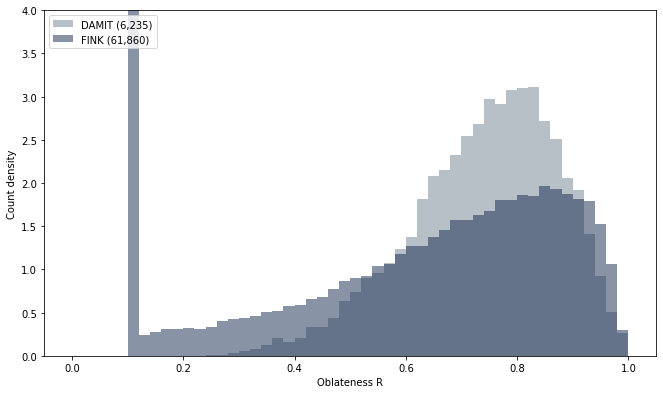

In [50]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
fig, ax = plt.subplots(figsize=(10,6), 
                      gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

r = [0,1]
b = 50

colors = ['#15284F', '#F5622E']


# ax.hist( damit.R, range=r, bins=b, 
#         color='lightgray', 
#         density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )

ax.hist( damit.R2, range=r, bins=b, 
        color='slategray', 
        density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )
# ax.hist( data.loc[maskFINK,'SHG1G2_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

cond = (data.SHG1G2_dR<0.9) & maskFINK
ax.hist( data.loc[cond,'SHG1G2_R'], range=r, bins=b, 
         color=colors[0], 
        density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

ax.set_ylim(0,4)
ax.set_xlabel('Oblateness R')
ax.set_ylabel('Count density')
ax.legend(loc='upper left')

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)


Text(0.5, 0, '(FINK R - DAMIT R) / dR')

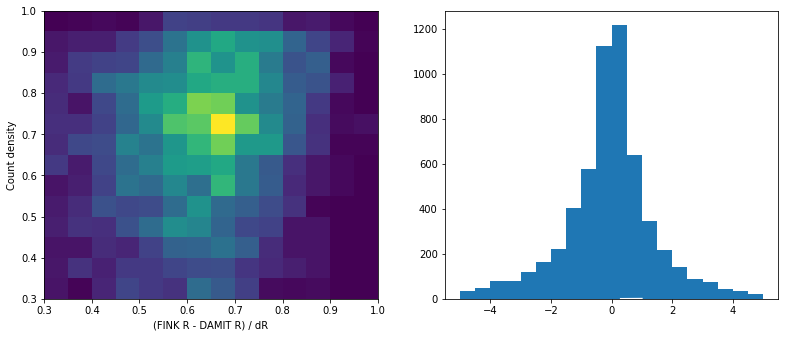

In [51]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5), 
fig, ax = plt.subplots(1, 2, figsize=(12,5), 
                       gridspec_kw={'right':0.975, 
                                  'top':0.95, 
                                  'bottom':0.15})

r = [0,1]
b = 50

colors = ['#15284F', '#F5622E']

x = damit.merge(data, left_on='number', right_on='sso_number')

# ax.scatter( x.R, x.SHG1G2_R ) 
ax[0].hist2d( x.R, x.SHG1G2_R, range=[[0.3,1],[0.3,1]], bins=14) 
xx = np.linspace(0.3,1,num=10)
ax[1].plot(xx,xx, color='white')

ax[1].hist( (x.R-x.SHG1G2_R)/x.SHG1G2_dR, range=[-5,5], bins=20 )



# ax.set_ylim(0,4)
ax[0].set_xlabel('FINK R')
ax[0].set_ylabel('Count density')

ax[0].set_xlabel('(FINK R - DAMIT R) / dR')

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)


In [52]:
# damit.sort_values(by='R').head(40)
cond = maskFINK & (data.SHG1G2_R>0.18)
data[cond].sort_values(by='SHG1G2_R').head(40)

,ssnamenr,HG_dG_g,HG_fit,HG_median_error_phot_1,HG_median_error_phot_2,HG_rms,HG_chi2red,HG_median_error_phot,HG_dH_g,HG_dG_r,...,spins.delta_RA,spins.delta_DEC,spins.err_RA,spins.err_DEC,spins.RA,spins.DEC,spins.dSpin,lon_orbit,lat_orbit,obliquity
80858,73304,0.120627,0.0,0.141534,0.127604,0.109696,0.547951,0.134588,0.095485,0.071977,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,56.778438,82.749432,30.340686
82889,7978,0.028720,0.0,0.116894,0.078313,0.060561,0.669550,0.093864,0.034254,0.021055,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,123.757297,88.967402,NaN
75496,18043,0.033847,0.0,0.123776,0.114540,0.080007,0.606771,0.118081,0.027408,0.030294,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,26.173630,86.894092,173.266236
68367,48340,0.059845,0.0,0.129304,0.094882,0.163338,5.680009,0.109786,0.079775,0.061787,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,83.547985,87.510417,NaN
7890,153113,0.079702,0.0,0.158341,0.115083,0.090184,0.855912,0.129869,0.075281,0.042047,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,90.415805,81.268001,98.702804
45409,61617,0.031590,0.0,0.105653,0.096187,0.098554,2.333014,0.100147,0.040613,0.030414,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,-64.402028,87.421953,NaN
77788,118414,0.060240,0.0,0.149009,0.112096,0.103961,0.895613,0.131968,0.067618,0.055107,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,-16.695577,79.349191,172.386071
59550,97564,0.114960,0.0,0.151011,0.122331,0.218165,5.397109,0.133645,0.099263,0.106443,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,39.354222,87.097400,5.463804
91393,42655,0.135862,0.0,0.121093,0.085737,0.257118,8.765571,0.099520,0.183175,0.153059,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,228.056107,84.233359,NaN
96930,63072,0.043664,0.0,0.136583,0.097495,0.124937,1.526361,0.107679,0.071378,0.042674,...,NaN,NaN,15.0,15.0,15.00000,15.00000,NaN,-33.453916,85.418740,3.792931


Text(0, 0.5, 'R')

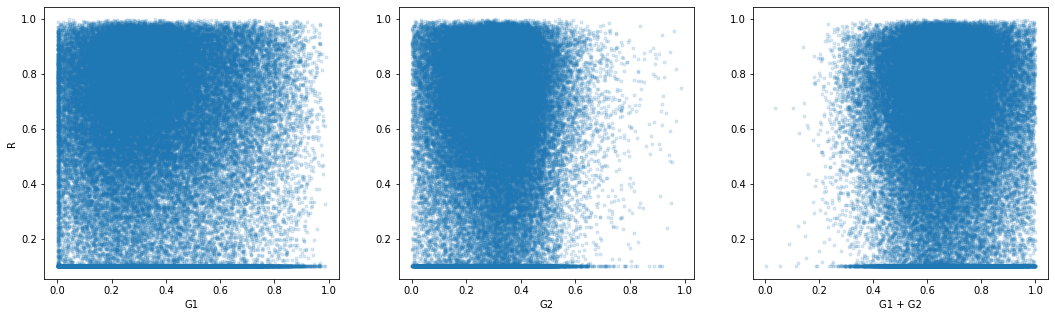

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

r = [0,1]
b = 50


cond = maskFINK

ax[0].scatter( data.loc[cond,'SHG1G2_G1_r'], data.loc[cond,'SHG1G2_R'], marker='.', alpha=0.15 )
ax[1].scatter( data.loc[cond,'SHG1G2_G2_r'], data.loc[cond,'SHG1G2_R'], marker='.', alpha=0.15 )
ax[2].scatter( data.loc[cond,'SHG1G2_G1_r']+data.loc[cond,'SHG1G2_G2_r'], data.loc[cond,'SHG1G2_R'], marker='.', alpha=0.15 )

ax[0].set_xlabel('G1')
ax[1].set_xlabel('G2')
ax[2].set_xlabel('G1 + G2')
ax[0].set_ylabel('R')

# ax.legend(loc='upper left')